# 06. PyTorch Custom Datasets

In [1]:
import torch
from torch import nn
import requests
import zipfile
from pathlib import Path
import os
import random 
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision import datasets


In [2]:
#setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
!nvidia-smi


Tue Sep 17 10:41:43 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   52C    P8              4W /   75W |      21MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Get data 

Our dataset is a subset of the Food101 dataset.


In [4]:
# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else: 
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and suhsi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, suhsi data...")
  f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi data...")
  zip_ref.extractall(image_path)

data\pizza_steak_sushi directory already exists... skipping download
Unzipping pizza, steak and sushi data...


## 2. data preparation and data exploration

In [5]:
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [7]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing and image

Let's write some code to:
1. Get all of the image paths 
2. Pick a random image path using Python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem` 
4. Since we're working with images, let's open the image with Python's PIL
5. We'll then show the image and print metadata

In [8]:
image_path

WindowsPath('data/pizza_steak_sushi')

Random image path: data\pizza_steak_sushi\train\pizza\2702825.jpg
Image class: pizza
Image height: 512
Image width: 512


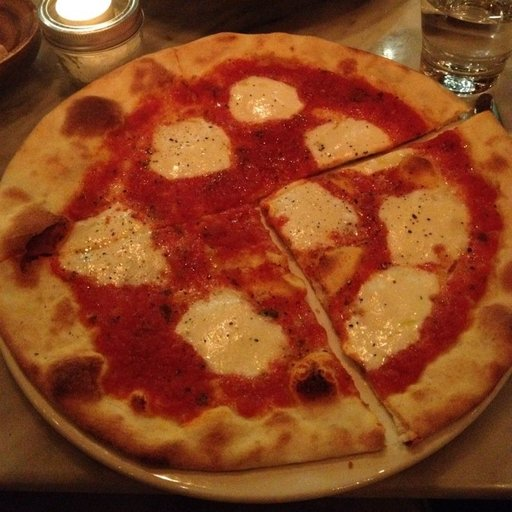

In [9]:
# Set seed
# random.seed(42)

# 1. Get all image paths 
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata 
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

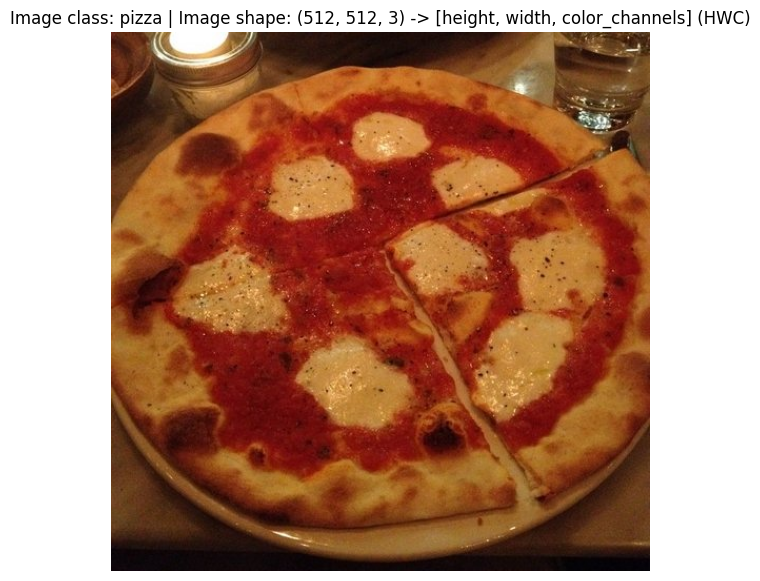

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels] (HWC)")
plt.axis(False);

In [11]:
img_as_array

array([[[106,  40,  28],
        [107,  43,  31],
        [ 98,  35,  20],
        ...,
        [ 89,  62,  33],
        [ 96,  69,  39],
        [110,  83,  53]],

       [[109,  45,  33],
        [104,  40,  28],
        [104,  42,  29],
        ...,
        [ 84,  57,  28],
        [ 91,  64,  35],
        [ 92,  65,  35]],

       [[112,  50,  39],
        [ 99,  40,  26],
        [106,  47,  33],
        ...,
        [ 78,  51,  22],
        [ 82,  52,  24],
        [ 82,  52,  24]],

       ...,

       [[ 13,   4,   9],
        [ 14,   5,  10],
        [ 14,   5,  10],
        ...,
        [  5,   3,   8],
        [  6,   4,   9],
        [  8,   6,  11]],

       [[ 14,   5,  10],
        [ 14,   5,  10],
        [ 14,   5,  10],
        ...,
        [  5,   3,   8],
        [  6,   4,   9],
        [  8,   6,  11]],

       [[ 15,   6,  11],
        [ 15,   6,  11],
        [ 14,   5,  10],
        ...,
        [  6,   4,   9],
        [  7,   5,  10],
        [  8,   6,  11]]

## 3. Transforming data 

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in our case, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`.
